In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [12]:
# 대출정보.txt
rent_df = pd.read_csv('../Data/대출정보.txt', sep=',', encoding='EUC-KR')
rent_df[:3]

,도서ID,대출일시
0,SS_213406,2004-11-15 12:33:01
1,SS_213528,2004-12-04 12:20:33
2,SS_213528,2004-11-18 18:05:08


In [13]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916709 entries, 0 to 916708
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   도서ID    916709 non-null  object
 1   대출일시    916709 non-null  object
dtypes: object(2)
memory usage: 14.0+ MB


In [26]:
import os

from mysql import connector
from dotenv import load_dotenv

# Access environment variables
load_dotenv()

NAME = os.getenv("DB_NAME")
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASSWORD")
IP = os.getenv("DB_IP")
PORT = os.getenv("DB_PORT")

In [27]:
class Database:
    _connection = None  # 클래스 변수로 연결 상태 관리

    @staticmethod
    def get_connection():
        if Database._connection is None or not Database._connection.is_connected():
            Database._connection = connector.connect(
                database = NAME,
                user = USER,
                password = PASSWORD,
                host = IP,
                port = PORT
            )
        return Database._connection

In [28]:
def batch_insert(query, values_list, batch_size=1000):
    """
    Batch Insert with transaction optimization
    :param query: SQL query
    :param values_list: List of values to insert
    :param batch_size: Number of rows per batch
    """
    try:
        conn = Database.get_connection()
        cursor = conn.cursor()

        # 트랜잭션 시작
        total_rows = len(values_list)
        for i in range(0, total_rows, batch_size):
            batch = values_list[i : i + batch_size]
            cursor.executemany(query, batch)  # Batch Insert
            conn.commit()  # Batch마다 커밋 (너무 자주 커밋하지 않음)

        cursor.close()
    except connector.Error as e:
        print(f"Error: {e}")
        conn.rollback()  # 오류 발생 시 롤백


# SQL 쿼리
query = """
INSERT INTO rent 
(ID, rent_date, TAG) 
VALUES (%s, %s, %s)
"""

# 데이터 준비
values_list = [
    (
        rent_df.iloc[i, 0], rent_df.iloc[i, 1], rent_df.iloc[i, 3]
    )
    for i in range(len(rent_df))
]

# Batch Insert 실행
batch_insert(query, values_list, batch_size=1000)


In [14]:
rent_df.isnull().sum() / len(rent_df)

도서ID    0.0
대출일시    0.0
dtype: float64

In [15]:
# 각 열에서 가장 긴 데이터 길이 계산
max_lengths = rent_df.astype(str).applymap(len).max()

# 결과 출력
print(max_lengths)

/tmp/ipykernel_1663/1290547690.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_lengths = rent_df.astype(str).applymap(len).max()


도서ID     9
대출일시    19
dtype: int64


In [16]:
# '대출일시'에서 월 추출
rent_df['대출월'] = pd.to_datetime(rent_df['대출일시']).dt.month

In [17]:
# 월별 데이터 카운트
month_counts = rent_df['대출월'].value_counts().sort_index()

In [18]:
month_counts

대출월
1      52315
2      38463
3     102988
4      89882
5      98078
6      82872
7      52480
8      45394
9      97414
10     85139
11     97207
12     74477
Name: count, dtype: int64

In [24]:
# '대출월' 기준으로 학기와 비학기 구분
rent_df['TAG'] = rent_df['대출월'].apply(lambda x: '방학' if x in [1, 2, 7, 8] else '학기')

# 결과 확인
print(rent_df[['대출월', 'TAG']][10000:12100])

       대출월 TAG
10000   11  학기
10001   11  학기
10002    9  학기
10003    4  학기
10004   12  학기
...    ...  ..
12095    5  학기
12096    2  방학
12097   11  학기
12098    7  방학
12099    9  학기

[2100 rows x 2 columns]


In [25]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916709 entries, 0 to 916708
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   도서ID    916709 non-null  object
 1   대출일시    916709 non-null  object
 2   대출월     916709 non-null  int32 
 3   TAG     916709 non-null  object
dtypes: int32(1), object(3)
memory usage: 24.5+ MB


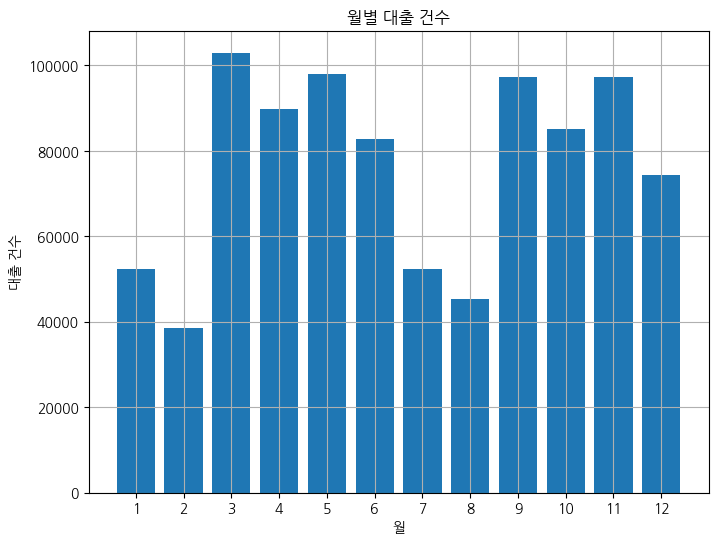

In [10]:
# 한글 폰트 설정
mpl.rc('font', family='NanumGothic')  # 나눔고딕 폰트 예시

plt.figure(figsize=(8, 6))
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('월')
plt.ylabel('대출 건수')
plt.title('월별 대출 건수')
plt.xticks(month_counts.index)  # 월 값 표시
plt.grid(True)
plt.show()

In [11]:
# 단행본(도서)정보.txt
book_df = pd.read_csv('../Data/단행본(도서)정보.txt', sep=',', encoding='EUC-KR')
book_df[:3]

,도서ID,등록일자,수서방법,분류코드,ISBN,서명,저자,출판사,출판년도,소장위치
0,SS_270312,2017-09-13,학과신청,194,9782020658706,Le courage de la verite :le gouvernement de so...,"Foucault, Michel",Gallimard,2009,4층인문
1,SS_233793,2008-10-13,수서정보없음,160,9788995605189,김나지움 논리학입문,"Hegel, Georg Wilhelm Friedrich",용의숲,2008,보존서고
2,SS_233788,2008-10-13,수서정보없음,160,9788995605189,김나지움 논리학입문,"Hegel, Georg Wilhelm Friedrich",용의숲,2008,4층인문


In [25]:
# '도서ID' 기준으로 join 수행
merge_df = pd.merge(rent_df, book_df, on='도서ID', how='left')

merge_df[:5]

,도서ID,대출일시,대출월,등록일자,수서방법,분류코드,ISBN,서명,저자,출판사,출판년도,소장위치
0,SS_213406,2004-11-15 12:33:01,11,1994-09-12,수서정보없음,808.3,0,현대소설원론,박종홍,중문출판사,1993,보존서고
1,SS_213528,2004-12-04 12:20:33,12,1994-10-04,수서정보없음,001.6424,0,Prolog,태세효,大光書林,1992,보존서고
2,SS_213528,2004-11-18 18:05:08,11,1994-10-04,수서정보없음,001.6424,0,Prolog,태세효,大光書林,1992,보존서고
3,SS_213529,2004-12-03 11:30:45,12,1994-10-04,수서정보없음,001.6424,0,Prolog,태세효,大光書林,1992,보존서고
4,SS_213529,2004-11-10 12:56:59,11,1994-10-04,수서정보없음,001.6424,0,Prolog,태세효,大光書林,1992,보존서고


In [26]:
merge_df = merge_df.drop(columns=['대출일시', '등록일자', '수서방법', 'ISBN', '서명', '저자', '출판사', '출판년도', '소장위치'])
merge_df[:5]

,도서ID,대출월,분류코드
0,SS_213406,11,808.3
1,SS_213528,12,001.6424
2,SS_213528,11,001.6424
3,SS_213529,12,001.6424
4,SS_213529,11,001.6424


In [33]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916707 entries, 0 to 916708
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   도서ID    916707 non-null  object
 1   대출월     916707 non-null  int32 
 2   분류코드    916707 non-null  object
dtypes: int32(1), object(2)
memory usage: 24.5+ MB


In [38]:
merge_df = merge_df[merge_df['분류코드'] != '0198129009 (v.2)']
merge_df['분류코드'] = merge_df['분류코드'].str.replace(',', '.')
merge_df['분류코드'] = merge_df['분류코드'].str.replace('..', '.')
# 숫자와 소수점만 남기기
merge_df['분류코드'] = merge_df['분류코드'].str.extract(r'([\d.]+)')
merge_df['분류코드'] = merge_df['분류코드'].str.rstrip('.')
merge_df['분류코드'] = merge_df['분류코드'].astype(float)

In [42]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
group_name = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900']

merge_df['분류'] = pd.cut(merge_df['분류코드'], bins, labels = group_name)
merge_df[:5]

,도서ID,대출월,분류코드,분류
0,SS_213406,11,808.3000,800
1,SS_213528,12,1.6424,0
2,SS_213528,11,1.6424,0
3,SS_213529,12,1.6424,0
4,SS_213529,11,1.6424,0


In [54]:
# 카테고리별 월별 카운트 (피벗 테이블 생성)
pivot_table = merge_df.pivot_table(index='분류', columns='대출월', aggfunc='size', fill_value=0, observed=False)

# 결과 출력
display(pivot_table)

대출월,1,2,3,4,5,6,7,8,9,10,11,12
분류,,,,,,,,,,,,
0,2260,1758,3766,3087,3467,2775,2002,1785,3437,3025,3623,2602
100,11018,8716,25363,22919,23107,19351,11135,10125,22989,20039,22725,18089
200,6216,5159,13953,12551,13532,11704,6605,6089,12866,11773,13095,10253
300,354,272,1104,1186,1379,853,547,449,1175,998,1397,761
400,9482,6631,16327,11795,11918,11150,8820,7549,14503,11468,12491,10707
500,0,1,0,2,1,1,1,0,1,1,4,1
600,1549,1124,2675,2744,3063,2221,1546,1347,2806,2910,2790,2059
700,7067,5109,13803,12674,14402,12060,7382,6388,13591,11975,14622,10112
800,2017,1811,5827,4391,4499,3897,2242,2092,5126,3956,4434,3270


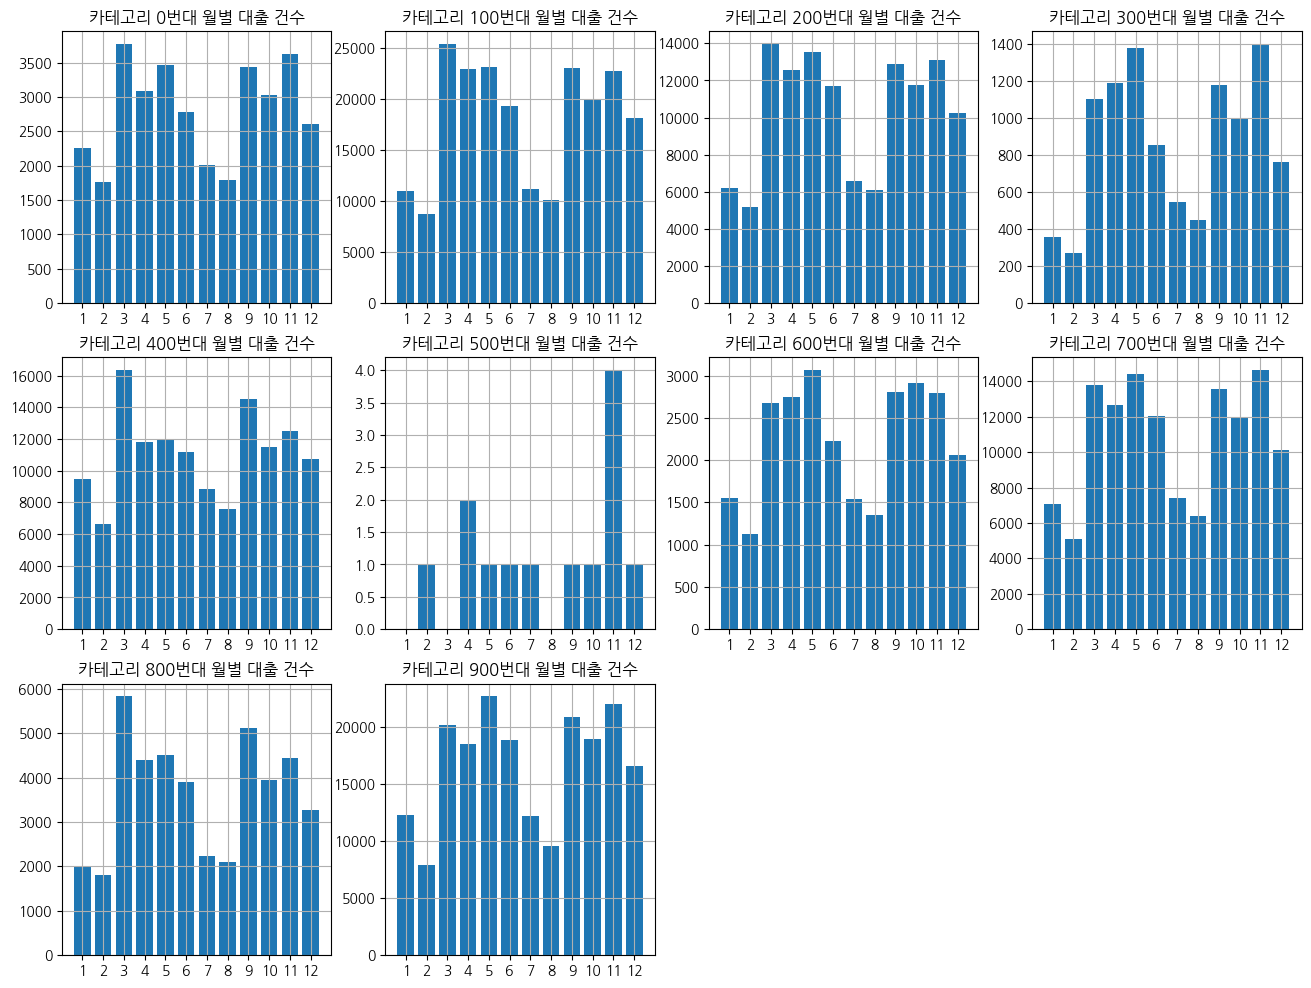

In [63]:
# 서브플롯 설정 (3x4 그리드)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()  # 1차원 배열로 변환

# 각 카테고리별로 그래프 생성
categories = pivot_table.index
idx = 0

for category in categories:
    ax = axes[idx]
    ax.bar(pivot_table.columns, pivot_table.loc[category])
    #ax.set_xlabel('월')
    #ax.set_ylabel('대출 건수')
    ax.set_title(f'카테고리 {category}번대 월별 대출 건수')
    ax.grid(True)
    ax.set_xticks(pivot_table.columns)
    idx += 1

fig.delaxes(axes[10])
fig.delaxes(axes[11])
# 그래프 표시
plt.show()